In [2]:
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table
# from archivalCGMtools.loc4 import slime
from scipy import interpolate
#from goodies import closest
from mpl_toolkits import mplot3d
from astropy import stats as astats
%matplotlib inline
import pickle

from pyslime import slime
from pyslime import utils as psu

In [3]:
out_pickle_file = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/mapping_BP_z0p0_1sigma.pick"
smpackage = pickle.load(open(out_pickle_file,'rb'))

In [4]:
smrhobins = smpackage['smrhobins']
binsize = 0.1
midbins = 0.5*smrhobins[:-1]+ 0.5*smrhobins[1:]

In [5]:
nonan = ~np.isnan(smpackage['medvals_bp'])

In [7]:
# smpackage['medvals_bp'][nonan]

In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline

mapfunc = InterpolatedUnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan])

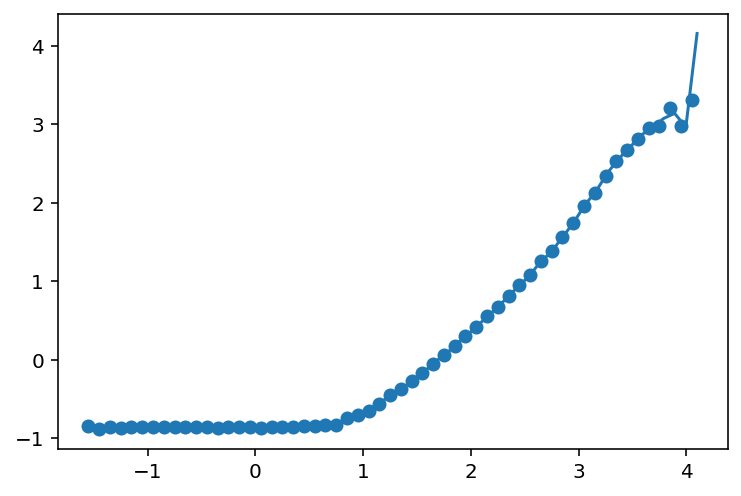

In [9]:
xfull = np.linspace(-1, 4.1)
plt.plot(xfull, mapfunc(xfull), label='spline')
# plt.plot(midbins, terpSlimeBp(midbins), label='interp')
plt.scatter(midbins, smpackage['medvals_bp'])

In [10]:
from scipy import stats

cutidxlow = -12
cutidxhi = -3

cut = (midbins>=midbins[cutidxlow]) & (midbins<=midbins[cutidxhi])
x = midbins[cut]
y = smpackage['medvals_bp'][cut]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

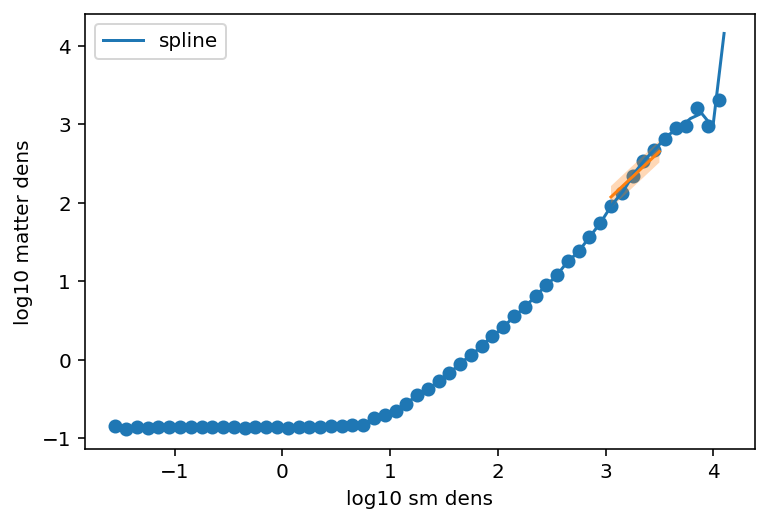

In [11]:
xfull = np.linspace(-1, 4.1)
plt.plot(xfull, mapfunc(xfull), label='spline')
plt.scatter(midbins, smpackage['medvals_bp'])
xplot = np.linspace(midbins[cutidxlow], 3.5)
line = slope*xplot + intercept
plt.plot(xplot, line)
plt.fill_between(xplot, line+std_err, line-std_err, alpha=0.3)
plt.xlabel('log10 sm dens')
plt.ylabel('log10 matter dens');
plt.legend();

In [12]:
coma_dens = 3.538825
coma_dens, slope*coma_dens + intercept

(3.538825, 2.7010216241890284)

In [13]:
mapfunc(3.45)

array(2.6684755)

In [37]:
mapfunc(3.4574211329533497)

array(2.67838699)

In [38]:
10**2.67838699

476.85571289667365